# Selección de features y modelización

## Importación de librerías

In [1]:
# Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para manipulación y análisis de datos
import numpy as np
import pandas as pd


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, recall_score, auc

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve


from toolbox_DS import *
from toolbox_ML import *


import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')


## Carga de datos

Train

In [2]:
train_set = pd.read_csv('./data/train_set.csv')
train_set

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Response,income_missing,age,customes_seniority,Household_members,Total_amount,Total_purchase,Median_amount_purchase,Total_cmp,Total_%_cmp
0,5675,1960,PhD,Divorced,50611.0,0,1,2012-10-04,98,459,...,0,0,55,3,2.0,493,22,22.409091,1,0.2
1,5543,1966,Graduation,Together,57811.0,0,1,2013-06-24,49,545,...,0,0,49,2,3.0,802,25,32.080000,1,0.2
2,3011,1965,Graduation,Married,69139.0,0,1,2014-01-27,23,86,...,0,0,50,1,3.0,227,11,20.636364,0,0.0
3,535,1987,Graduation,Divorced,81361.0,0,0,2014-02-25,18,163,...,0,0,28,1,1.0,778,27,28.814815,0,0.0
4,10755,1976,2n Cycle,Married,23718.0,1,0,2013-09-02,76,6,...,0,0,39,2,3.0,81,9,9.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,5320,1973,Master,Divorced,44051.0,1,1,2013-01-29,20,79,...,1,0,42,2,3.0,171,12,14.250000,0,0.0
1786,2894,1985,Graduation,Single,72903.0,0,0,2013-10-29,74,1067,...,1,0,30,2,1.0,2013,21,95.857143,3,0.6
1787,1726,1970,Graduation,Single,22585.0,0,0,2013-03-18,23,3,...,1,0,45,2,1.0,81,5,16.200000,1,0.2
1788,6905,1994,Graduation,Together,80685.0,0,0,2012-08-22,55,241,...,0,0,21,3,2.0,1004,21,47.809524,0,0.0


Test

In [3]:
test_set = pd.read_csv('./data/test_set.csv')
test_set.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Complain,Response,age,customes_seniority,Household_members,Total_amount,Total_purchase,Median_amount_purchase,Total_cmp,Total_%_cmp
0,2853,1980,Graduation,Single,51766.0,1,0,2014-03-11,74,60,...,0,0,35,1,2.0,275,12,22.916667,0,0.0
1,10492,1959,Graduation,Together,38285.0,2,1,2014-06-24,96,2,...,0,0,56,1,5.0,10,4,2.500000,0,0.0
2,8939,1959,Graduation,Divorced,61250.0,0,1,2012-12-16,49,382,...,0,0,56,3,2.0,730,25,29.200000,0,0.0
3,6274,1948,Master,Married,83790.0,0,0,2013-11-15,81,1076,...,0,0,67,2,2.0,1615,25,64.600000,2,0.4
4,10232,1963,PhD,Divorced,48799.0,0,1,2013-11-05,9,174,...,0,0,52,2,2.0,331,15,22.066667,0,0.0


Imputo los cambios que vengo aplicando al dataset.    
Train

In [4]:
# Cambio el índice
train_set.set_index('ID', inplace=True)

# Cambio tipo a datetime
train_set['Dt_Customer'] = pd.to_datetime(train_set['Dt_Customer'])

# Cambiar tipo a categóricas
cols_to_category = ['Education', 'Marital_Status']
train_set[cols_to_category] = train_set[cols_to_category].astype('category')

# Elimino columna 'income_missing'
train_set = train_set.drop(columns=['income_missing', 'Year_Birth','Total_%_cmp','Dt_Customer','Median_amount_purchase'])

# Elimino el outlier de Income
train_set = train_set.loc[train_set['Income'] !=666666]

Y también al test

In [5]:
# Cambio el índice
test_set.set_index('ID', inplace=True)

# Cambio tipo a datetime
test_set['Dt_Customer'] = pd.to_datetime(test_set['Dt_Customer'])

# Cambiar tipo a categóricas
cols_to_category = ['Education', 'Marital_Status']
test_set[cols_to_category] = test_set[cols_to_category].astype('category')

# Elimino columna 'income_missing'
test_set = test_set.drop(columns=['Year_Birth','Total_%_cmp','Dt_Customer','Median_amount_purchase'])

# Elimino el outlier de Income
test_set = test_set.loc[test_set['Income'] !=666666]

## Transformación de variables

In [6]:
X_train = train_set.drop(columns='Response')
y_train = train_set['Response']

X_test = test_set.drop(columns='Response')
y_test = test_set['Response']

In [7]:
features_num = X_train.select_dtypes(['int','float']).columns
features_cat = X_train.select_dtypes(['object', 'category']).columns
print('features_num', features_num)
print('features_cat', features_cat)

features_num Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'age', 'customes_seniority',
       'Household_members', 'Total_amount', 'Total_purchase', 'Total_cmp'],
      dtype='object')
features_cat Index(['Education', 'Marital_Status'], dtype='object')


In [42]:
# Definimos el OrdinalEncoder con el mapeo de 'education_ode'
ordinal_encoder = OrdinalEncoder(categories=[['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']])

categorical_features_onehot = ['Marital_Status']
categorical_features_ordinal = ['Education']
numerical_features = features_num

# Definimos el SimpleImputer
imputer = SimpleImputer(strategy='median') # Me da problemas el gridsearch.... Cuerioso porque antes no...

preprocessor = ColumnTransformer(
    transformers=[
        ('num', imputer, numerical_features),
        ('cat_onehot', OneHotEncoder(), categorical_features_onehot),
        ('cat_ordinal', Pipeline([
            ('ordinal', ordinal_encoder),
            ('scaler', MinMaxScaler())
        ]), categorical_features_ordinal)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocesor',preprocessor),
    ('algoritmo', RandomForestClassifier())
])

pipeline.fit(X_train,y_train)

X_train_transform = pipeline.named_steps['preprocesor'].transform(X_train)
X_test_transform = pipeline.named_steps['preprocesor'].transform(X_test)


In [9]:
features_transformed = pipeline.named_steps['preprocesor'].get_feature_names_out()
features_transformed

array(['num__Income', 'num__Kidhome', 'num__Teenhome', 'num__Recency',
       'num__MntWines', 'num__MntFruits', 'num__MntMeatProducts',
       'num__MntFishProducts', 'num__MntSweetProducts',
       'num__MntGoldProds', 'num__NumDealsPurchases',
       'num__NumWebPurchases', 'num__NumCatalogPurchases',
       'num__NumStorePurchases', 'num__NumWebVisitsMonth',
       'num__AcceptedCmp3', 'num__AcceptedCmp4', 'num__AcceptedCmp5',
       'num__AcceptedCmp1', 'num__AcceptedCmp2', 'num__Complain',
       'num__age', 'num__customes_seniority', 'num__Household_members',
       'num__Total_amount', 'num__Total_purchase', 'num__Total_cmp',
       'cat_onehot__Marital_Status_Alone',
       'cat_onehot__Marital_Status_Divorced',
       'cat_onehot__Marital_Status_Married',
       'cat_onehot__Marital_Status_Others',
       'cat_onehot__Marital_Status_Single',
       'cat_onehot__Marital_Status_Together',
       'cat_onehot__Marital_Status_Widow', 'cat_ordinal__Education'],
      dtype=object)

In [10]:
X_train_transform_df = pd.DataFrame(X_train_transform, columns=(features_transformed))
X_train_transform_df

,num__Income,num__Kidhome,num__Teenhome,num__Recency,num__MntWines,num__MntFruits,num__MntMeatProducts,num__MntFishProducts,num__MntSweetProducts,num__MntGoldProds,...,num__Total_purchase,num__Total_cmp,cat_onehot__Marital_Status_Alone,cat_onehot__Marital_Status_Divorced,cat_onehot__Marital_Status_Married,cat_onehot__Marital_Status_Others,cat_onehot__Marital_Status_Single,cat_onehot__Marital_Status_Together,cat_onehot__Marital_Status_Widow,cat_ordinal__Education
0,50611.0,0.0,1.0,98.0,459.0,0.0,24.0,6.0,0.0,4.0,...,22.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00
1,57811.0,0.0,1.0,49.0,545.0,7.0,114.0,37.0,21.0,78.0,...,25.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50
2,69139.0,0.0,1.0,23.0,86.0,12.0,75.0,33.0,15.0,6.0,...,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.50
3,81361.0,0.0,0.0,18.0,163.0,23.0,424.0,27.0,65.0,76.0,...,27.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.50
4,23718.0,1.0,0.0,76.0,6.0,3.0,14.0,15.0,7.0,36.0,...,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,44051.0,1.0,1.0,20.0,79.0,7.0,58.0,6.0,3.0,18.0,...,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.75
1785,72903.0,0.0,0.0,74.0,1067.0,138.0,750.0,0.0,19.0,39.0,...,21.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.50
1786,22585.0,0.0,0.0,23.0,3.0,9.0,15.0,13.0,2.0,39.0,...,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.50
1787,80685.0,0.0,0.0,55.0,241.0,45.0,604.0,34.0,26.0,54.0,...,21.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50


In [11]:
X_train_transform_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1789 entries, 0 to 1788
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   num__Income                          1789 non-null   float64
 1   num__Kidhome                         1789 non-null   float64
 2   num__Teenhome                        1789 non-null   float64
 3   num__Recency                         1789 non-null   float64
 4   num__MntWines                        1789 non-null   float64
 5   num__MntFruits                       1789 non-null   float64
 6   num__MntMeatProducts                 1789 non-null   float64
 7   num__MntFishProducts                 1789 non-null   float64
 8   num__MntSweetProducts                1789 non-null   float64
 9   num__MntGoldProds                    1789 non-null   float64
 10  num__NumDealsPurchases               1789 non-null   float64
 11  num__NumWebPurchases          

In [49]:
X_test_transform_df = pd.DataFrame(X_test_transform, columns=features_transformed)
X_test_transform_df

,num__Income,num__Kidhome,num__Teenhome,num__Recency,num__MntWines,num__MntFruits,num__MntMeatProducts,num__MntFishProducts,num__MntSweetProducts,num__MntGoldProds,...,num__Total_purchase,num__Total_cmp,cat_onehot__Marital_Status_Alone,cat_onehot__Marital_Status_Divorced,cat_onehot__Marital_Status_Married,cat_onehot__Marital_Status_Others,cat_onehot__Marital_Status_Single,cat_onehot__Marital_Status_Together,cat_onehot__Marital_Status_Widow,cat_ordinal__Education
0,51766.0,1.0,0.0,74.0,60.0,51.0,87.0,6.0,20.0,51.0,...,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.50
1,38285.0,2.0,1.0,96.0,2.0,0.0,5.0,2.0,0.0,1.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50
2,61250.0,0.0,1.0,49.0,382.0,138.0,65.0,60.0,26.0,59.0,...,25.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.50
3,83790.0,0.0,0.0,81.0,1076.0,16.0,417.0,42.0,48.0,16.0,...,25.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.75
4,48799.0,0.0,1.0,9.0,174.0,18.0,81.0,28.0,6.0,24.0,...,15.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,62335.0,0.0,1.0,87.0,243.0,131.0,217.0,85.0,6.0,26.0,...,21.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.50
444,44393.0,1.0,1.0,86.0,24.0,2.0,20.0,2.0,2.0,10.0,...,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.50
445,54342.0,1.0,1.0,74.0,84.0,10.0,34.0,11.0,10.0,28.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.25
446,34421.0,1.0,0.0,81.0,3.0,3.0,7.0,6.0,2.0,9.0,...,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.50


## Features Selection

El problema de utlizar la fórmula es que se pierde explicabilidady en este contexto es muy importante.    
Voy a hacer algún modelo 'a mano'.

#### Selección de features numéricas mediante SelectKBeest y Anova

In [12]:
selector =SelectKBest(f_regression, k = 20)

x_data_kbest = selector.fit_transform(X_train_transform_df, y_train)

features_kbest= selector.get_feature_names_out()
features_kbest

array(['num__Income', 'num__Teenhome', 'num__Recency', 'num__MntWines',
       'num__MntFruits', 'num__MntMeatProducts', 'num__MntFishProducts',
       'num__MntGoldProds', 'num__NumWebPurchases',
       'num__NumCatalogPurchases', 'num__AcceptedCmp3',
       'num__AcceptedCmp4', 'num__AcceptedCmp5', 'num__AcceptedCmp1',
       'num__AcceptedCmp2', 'num__customes_seniority',
       'num__Household_members', 'num__Total_amount',
       'num__Total_purchase', 'num__Total_cmp'], dtype=object)

#### Selección usando modelo RFE

In [13]:
# Instnacio modelo de clasificación
rf_RFE = RandomForestRegressor(max_depth=5,random_state=42)

# Sobre el modelo instancio el rfe
rfe = RFE(
    estimator=rf_RFE,
    n_features_to_select=20,
    step=1, 
    )

# Entreno el modelo rfe
rfe.fit(X_train_transform_df,y_train)
print(rfe.ranking_)
pd.DataFrame(rfe.ranking_,columns=['ranking'], index=features_transformed).sort_values('ranking')
features_RFE= rfe.get_feature_names_out()
features_RFE

[ 1 11  6  1  1  1  1  1  1  1  1  2  1  1  1  1  3 12  9 13 14  1  1  1
  1  1  1 15  7  4 16  5  8 10  1]


array(['num__Income', 'num__Recency', 'num__MntWines', 'num__MntFruits',
       'num__MntMeatProducts', 'num__MntFishProducts',
       'num__MntSweetProducts', 'num__MntGoldProds',
       'num__NumDealsPurchases', 'num__NumCatalogPurchases',
       'num__NumStorePurchases', 'num__NumWebVisitsMonth',
       'num__AcceptedCmp3', 'num__age', 'num__customes_seniority',
       'num__Household_members', 'num__Total_amount',
       'num__Total_purchase', 'num__Total_cmp', 'cat_ordinal__Education'],
      dtype=object)

#### Selección por SFS

In [14]:
# Instancio modelo clasificación
rf_sfs = RandomForestRegressor(max_depth=5,random_state=42)
# Instancio el modelo de la features selection
sfs_fordward = SequentialFeatureSelector(
    rf_sfs,
    n_features_to_select=20,
    cv = 3,
    )

# Entreno el modelo de features_selection
sfs_fordward.fit(X_train_transform_df,y_train)
features_SFS= sfs_fordward.get_feature_names_out()

### Hard Voting

In [15]:
listas_features = [features_kbest,features_RFE,features_SFS]
dicc_hard_voting = {}

for col in features_transformed:
    count = 0
    for lista in listas_features:
        if col in lista:
            count +=1
    dicc_hard_voting[col]=count
pprint(dicc_hard_voting)

{'cat_onehot__Marital_Status_Alone': 1,
 'cat_onehot__Marital_Status_Divorced': 0,
 'cat_onehot__Marital_Status_Married': 0,
 'cat_onehot__Marital_Status_Others': 1,
 'cat_onehot__Marital_Status_Single': 0,
 'cat_onehot__Marital_Status_Together': 1,
 'cat_onehot__Marital_Status_Widow': 1,
 'cat_ordinal__Education': 2,
 'num__AcceptedCmp1': 1,
 'num__AcceptedCmp2': 2,
 'num__AcceptedCmp3': 3,
 'num__AcceptedCmp4': 2,
 'num__AcceptedCmp5': 1,
 'num__Complain': 1,
 'num__Household_members': 3,
 'num__Income': 2,
 'num__Kidhome': 1,
 'num__MntFishProducts': 2,
 'num__MntFruits': 2,
 'num__MntGoldProds': 3,
 'num__MntMeatProducts': 3,
 'num__MntSweetProducts': 2,
 'num__MntWines': 2,
 'num__NumCatalogPurchases': 2,
 'num__NumDealsPurchases': 1,
 'num__NumStorePurchases': 2,
 'num__NumWebPurchases': 1,
 'num__NumWebVisitsMonth': 2,
 'num__Recency': 3,
 'num__Teenhome': 2,
 'num__Total_amount': 2,
 'num__Total_cmp': 3,
 'num__Total_purchase': 2,
 'num__age': 1,
 'num__customes_seniority': 3}


In [16]:
features_hard_voting = []

for i,j in dicc_hard_voting.items():
    if j == 2 or j == 3:
        features_hard_voting.append(i)
features_hard_voting

['num__Income',
 'num__Teenhome',
 'num__Recency',
 'num__MntWines',
 'num__MntFruits',
 'num__MntMeatProducts',
 'num__MntFishProducts',
 'num__MntSweetProducts',
 'num__MntGoldProds',
 'num__NumCatalogPurchases',
 'num__NumStorePurchases',
 'num__NumWebVisitsMonth',
 'num__AcceptedCmp3',
 'num__AcceptedCmp4',
 'num__AcceptedCmp2',
 'num__customes_seniority',
 'num__Household_members',
 'num__Total_amount',
 'num__Total_purchase',
 'num__Total_cmp',
 'cat_ordinal__Education']

In [17]:
# Instancio modelos
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
xgb = XGBClassifier(max_depth=10, scale_pos_weight=ratio,random_state = 42)
rf = RandomForestClassifier(max_depth=10, random_state=42, class_weight='balanced')
lgb = LGBMClassifier(max_depth=10, is_unbalance = True, objective= 'binary', random_state = 42, verbose = -1)

In [18]:
modelos = (xgb,rf,lgb)
features_list = (features_kbest,features_RFE,features_SFS,features_hard_voting)
model_name = ('XGBoost', 'RandomForest', 'LightGBM')
features_name = ('features_kbest','features_RFE','features_SFS','features_hard_voting')

best_result = {}

for model, name in zip(modelos, model_name):
    for i,lista in enumerate(features_list):
        score = cross_val_score(model, X_train_transform_df[lista], y_train, cv=3, scoring=make_scorer(recall_score, pos_label=1))
        best_score = np.mean(score)
        best_result['name'] = (lista,best_score)

        print(f'Para el modelo {name} con la lista {features_name[i]}: {best_score:.2f}')

Para el modelo XGBoost con la lista features_kbest: 0.47
Para el modelo XGBoost con la lista features_RFE: 0.49
Para el modelo XGBoost con la lista features_SFS: 0.56
Para el modelo XGBoost con la lista features_hard_voting: 0.51
Para el modelo RandomForest con la lista features_kbest: 0.33
Para el modelo RandomForest con la lista features_RFE: 0.34
Para el modelo RandomForest con la lista features_SFS: 0.42
Para el modelo RandomForest con la lista features_hard_voting: 0.32
Para el modelo LightGBM con la lista features_kbest: 0.51
Para el modelo LightGBM con la lista features_RFE: 0.52
Para el modelo LightGBM con la lista features_SFS: 0.58
Para el modelo LightGBM con la lista features_hard_voting: 0.53


Con una lista máx. de 20 variables, el mejor algoritmo sería el LightGBM con la lista features_SFS con 0.61 de recall de la clase positiva

## Modelización

### Prueba de modelos con todas las variables

In [19]:
pipe = Pipeline(steps=[
    ('preprocesor', preprocessor),
    ('algoritmo', RandomForestClassifier())
])


# Definir el grid de hiperparámetros
grid = [
    {'algoritmo': [RandomForestClassifier()],
     'algoritmo__max_depth': [5, 10, 15],
     'algoritmo__n_estimators': [50, 100, 200],
     'algoritmo__class_weight':['balanced']},
   
    {'algoritmo': [XGBClassifier()],
     'algoritmo__learning_rate': [0.1, 0.3, 0.5],
     'algoritmo__n_estimators': [100, 500, 1000],
     'algoritmo__scale_pos_weight':[ratio]},
    
    {'algoritmo': [LGBMClassifier()],
     'algoritmo__learning_rate': [0.1, 0.3, 0.5],
     'algoritmo__n_estimators': [100, 500, 1000],
     'algoritmo__is_unbalance' : [True],
     'algoritmo__objective': ['binary']}
]


# Realizar GridSearchCV con el scorer personalizado
grid_search = GridSearchCV(pipe, 
                           grid, 
                           cv=3, 
                           scoring=make_scorer(recall_score, pos_label=1), 
                           n_jobs=-1)


grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y parámetros
best_model = grid_search.best_estimator_
print("Mejor modelo y parámetros:", grid_search.best_params_)

c:\Users\Alfonso\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Mejor modelo y parámetros: {'algoritmo': RandomForestClassifier(), 'algoritmo__class_weight': 'balanced', 'algoritmo__max_depth': 5, 'algoritmo__n_estimators': 50}


In [20]:
grid_search.best_score_

nan

In [21]:
df_cv_results = pd.DataFrame(grid_search.cv_results_)
df_cv_results[['param_algoritmo','mean_test_score','std_test_score','rank_test_score']].sort_values('rank_test_score')

,param_algoritmo,mean_test_score,std_test_score,rank_test_score
0,RandomForestClassifier(),NaN,NaN,1
24,LGBMClassifier(),NaN,NaN,1
23,LGBMClassifier(),NaN,NaN,1
22,LGBMClassifier(),NaN,NaN,1
21,LGBMClassifier(),NaN,NaN,1
20,LGBMClassifier(),NaN,NaN,1
19,LGBMClassifier(),NaN,NaN,1
18,LGBMClassifier(),NaN,NaN,1
17,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,1
16,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,1


Haciendo un pipeline con todas las variables, el mejor sería un RandomForest con una recall de la clase positiva de 0.66

## Ajuste hiperparámetros

### RandomForest

In [39]:

param = {
    'n_estimators': [280,300,320],
    'max_depth': [5, 6,7],
    'min_samples_split': [3,4,5],
    'min_samples_leaf': [13,14,15],
    'class_weight': ['balanced']
}

grid_rf = GridSearchCV(rf, 
                       param_grid=param, 
                       cv=5, 
                       scoring=make_scorer(recall_score, pos_label=1), 
                       n_jobs=-1)

grid_rf.fit(X_train_transform_df, y_train)

# Obtener el mejor modelo y parámetros
best_model_rf = grid_rf.best_estimator_
best_params_rf = grid_rf.best_params_
print("Mejor modelo y parámetros:", best_params_rf)

# Imprimir el mejor resultado del recall para la clase positiva
best_recall_rf = grid_rf.best_score_
print("Mejor resultado del recall para la clase positiva:", best_recall_rf)


Mejor modelo y parámetros: {'class_weight': 'balanced', 'max_depth': 6, 'min_samples_leaf': 14, 'min_samples_split': 3, 'n_estimators': 300}
Mejor resultado del recall para la clase positiva: 0.7031446540880502


In [54]:

importancias = best_model_rf.feature_importances_
nombres_caracteristicas = X_train_transform_df.columns

importancias_df = pd.DataFrame({
    'Característica': nombres_caracteristicas,
    'Importancia': importancias
})

importancias_df.sort_values(by='Importancia', ascending=False, inplace=True)

print(importancias_df)


                         Característica  Importancia
26                       num__Total_cmp     0.145063
3                          num__Recency     0.112791
24                    num__Total_amount     0.082296
4                         num__MntWines     0.054649
22              num__customes_seniority     0.053656
15                    num__AcceptedCmp3     0.052393
0                           num__Income     0.052241
9                     num__MntGoldProds     0.050125
12             num__NumCatalogPurchases     0.043509
6                  num__MntMeatProducts     0.041272
17                    num__AcceptedCmp5     0.038569
14               num__NumWebVisitsMonth     0.033634
18                    num__AcceptedCmp1     0.031863
23               num__Household_members     0.031568
13               num__NumStorePurchases     0.026231
5                        num__MntFruits     0.021403
8                 num__MntSweetProducts     0.015789
2                         num__Teenhome     0.

### LigthGBM

In [55]:
param = {
    'max_depth': [3,4, 5],
    'min_child_samples': [2,4,8],
    'min_child_weight': [9,10,11],
    'learning_rate': [0.06,0.07,0.08],
    'n_estimators': [80,90,95],
    'is_unbalance' : [True],
    'objective': ['binary'],
}

grid_lgb = GridSearchCV(lgb, 
                       param_grid=param, 
                       cv=5, 
                       scoring=make_scorer(recall_score, pos_label=1), 
                       n_jobs=-1,
                       verbose= 1)

grid_lgb.fit(X_train_transform_df, y_train)

# Obtener el mejor modelo y parámetros
best_model_lgb = grid_lgb.best_estimator_
best_params_lgb = grid_lgb.best_params_
print("Mejor modelo y parámetros:", best_params_lgb)

# Imprimir el mejor resultado del recall para la clase positiva
best_recall_lgb = grid_lgb.best_score_
print("Mejor resultado del recall para la clase positiva:", best_recall_lgb)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejor modelo y parámetros: {'is_unbalance': True, 'learning_rate': 0.07, 'max_depth': 3, 'min_child_samples': 2, 'min_child_weight': 10, 'n_estimators': 90, 'objective': 'binary'}
Mejor resultado del recall para la clase positiva: 0.7598183088749128


In [35]:
importancias = best_model_lgb.feature_importances_
nombres_caracteristicas = X_train_transform_df.columns

importancias_df = pd.DataFrame({
    'Característica': nombres_caracteristicas,
    'Importancia': importancias
})

importancias_df.sort_values(by='Importancia', ascending=False, inplace=True)

print(importancias_df)

                         Característica  Importancia
3                          num__Recency          105
13               num__NumStorePurchases           56
23               num__Household_members           42
26                       num__Total_cmp           41
6                  num__MntMeatProducts           41
22              num__customes_seniority           37
9                     num__MntGoldProds           27
0                           num__Income           25
34               cat_ordinal__Education           25
14               num__NumWebVisitsMonth           20
4                         num__MntWines           19
5                        num__MntFruits           18
21                             num__age           16
7                  num__MntFishProducts           14
25                  num__Total_purchase           14
24                    num__Total_amount           14
11                 num__NumWebPurchases           12
15                    num__AcceptedCmp3       

### XGBoost

In [61]:
param = {
    'learning_rate': [0.07,0.08],
    'n_estimators': [50,100,150],
    'max_depth': [2,3,4],
    'min_child_weight': [7, 8, 9],  # Equivalente a min_samples_leaf en RandomForest
    'gamma': [0.2,0.3],  # Parámetro para controlar la regularización
    'subsample': [0.6,0.7],  # Porcentaje de muestras usadas para cada árbol
    'colsample_bytree': [0.4,0.5],  # Porcentaje de características usadas para cada árbol
    'scale_pos_weight': [ratio]  # Ponderación de clases para datasets desbalanceados
}


grid_xgb = GridSearchCV(xgb, 
                       param_grid=param, 
                       cv=5, 
                       scoring=make_scorer(recall_score, pos_label=1), 
                       n_jobs=-1,
                       verbose= 3)

grid_xgb.fit(X_train_transform_df, y_train)

# Obtener el mejor modelo y parámetros
best_model_xgb = grid_xgb.best_estimator_
best_params_xgb = grid_xgb.best_params_
print("Mejor modelo y parámetros:", best_params_xgb)

# Imprimir el mejor resultado del recall para la clase positiva
best_recall_xgb = grid_xgb.best_score_
print("Mejor resultado del recall para la clase positiva:", best_recall_xgb)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Mejor modelo y parámetros: {'colsample_bytree': 0.4, 'gamma': 0.3, 'learning_rate': 0.07, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 100, 'scale_pos_weight': 5.725563909774436, 'subsample': 0.6}
Mejor resultado del recall para la clase positiva: 0.7860237596086653


In [62]:
importancias = best_model_xgb.feature_importances_
nombres_caracteristicas = X_train_transform_df.columns

importancias_df = pd.DataFrame({
    'Característica': nombres_caracteristicas,
    'Importancia': importancias
})

importancias_df.sort_values(by='Importancia', ascending=False, inplace=True)

print(importancias_df)

                         Característica  Importancia
26                       num__Total_cmp     0.080912
15                    num__AcceptedCmp3     0.061919
24                    num__Total_amount     0.059815
22              num__customes_seniority     0.053364
17                    num__AcceptedCmp5     0.050956
3                          num__Recency     0.046861
0                           num__Income     0.045891
11                 num__NumWebPurchases     0.045032
23               num__Household_members     0.043471
4                         num__MntWines     0.040871
29   cat_onehot__Marital_Status_Married     0.038884
12             num__NumCatalogPurchases     0.034700
31    cat_onehot__Marital_Status_Single     0.033171
14               num__NumWebVisitsMonth     0.033019
7                  num__MntFishProducts     0.032614
2                         num__Teenhome     0.032511
13               num__NumStorePurchases     0.030303
25                  num__Total_purchase     0.

## Evaluación Modelos

#### Classification Report

In [63]:

# RandomForest
print('##### RandomForest #####')
y_pred_rf = grid_rf.predict(X_test_transform_df)

print(classification_report(y_test,y_pred_rf))
print()

# LigthGBM
print('##### LightGBM #####')
y_pred_lgb = grid_lgb.predict(X_test_transform_df)
print(classification_report(y_test,y_pred_lgb))
print()

# XGBoost
print('##### XGBoost #####')
y_pred_xgb = grid_xgb.predict(X_test_transform_df)
print(classification_report(y_test,y_pred_xgb))
print()



##### RandomForest #####
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       381
           1       0.44      0.63      0.52        67

    accuracy                           0.83       448
   macro avg       0.69      0.74      0.71       448
weighted avg       0.86      0.83      0.84       448


##### LightGBM #####
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       381
           1       0.46      0.75      0.57        67

    accuracy                           0.83       448
   macro avg       0.71      0.80      0.73       448
weighted avg       0.88      0.83      0.85       448


##### XGBoost #####
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       381
           1       0.47      0.78      0.59        67

    accuracy                           0.84       448
   macro avg       0.71      0.81      0.74       448
weight

#### Matrix de confusión

RandomForest

LightGBM

XGBoost



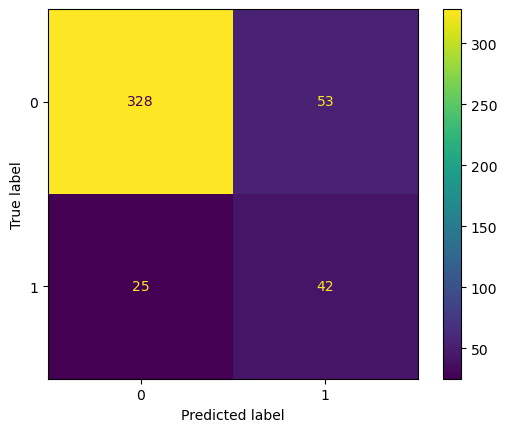

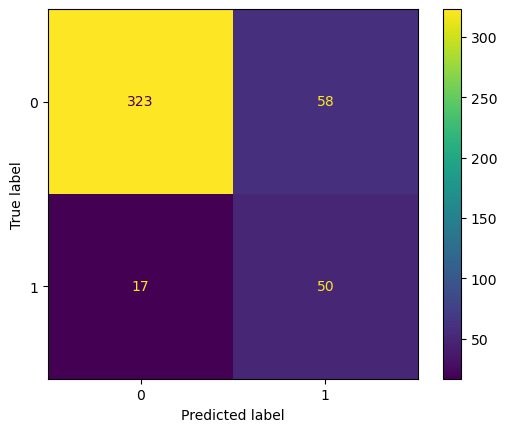

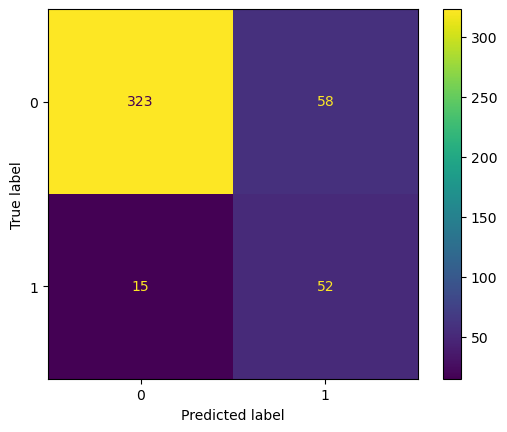

In [64]:
# RandomForest
print('RandomForest')
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
print()

# LightGBM
print('LightGBM')
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb)
disp_lgb.plot()
print()

# XGBoost
print('XGBoost')
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot()
print()

## Guardado modelos

In [65]:
import joblib
import os

path = './models/xgb_clas_1.joblib'

joblib.dump(grid_xgb,path)

['./models/xgb_clas_1.joblib']